# EEG classification

### Imports

In [ ]:
import mne
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Constructing epoched data 

### Importing raw data

In [ ]:
# Import the BrainVision data into an MNE Raw object
raw = mne.io.read_raw_brainvision('.vhdr')

# Read in the event information as MNE annotations
annot = mne.read_annotations('.vmrk')

# Add the annotations to our raw object so we can use them with the data
raw.set_annotations(annot)


### Creating epochs with event ids

In [ ]:
# Map with response markers only
event_dict = {
    'Stimulus/RE*ex*1_n*1_c_1*R*FB': 10004,
    'Stimulus/RE*ex*1_n*1_c_1*R*FG': 10005,
    'Stimulus/RE*ex*1_n*1_c_2*R': 10006,
    'Stimulus/RE*ex*1_n*2_c_1*R': 10007,
    'Stimulus/RE*ex*2_n*1_c_1*R': 10008,
    'Stimulus/RE*ex*2_n*2_c_1*R*FB': 10009,
    'Stimulus/RE*ex*2_n*2_c_1*R*FG': 10010,
    'Stimulus/RE*ex*2_n*2_c_2*R': 10011,
}

# Map for merged correct/error response markers
merged_event_dict = {
    'correct_response': 0,
    'error_response': 1
}

# Start and end of the segment
tmin, tmax = -0.1, 0.6

# Reconstruct the original events from Raw object
events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

# Merge correct/error response events
merged_events = mne.merge_events(events, [10004, 10005, 10009, 10010], merged_event_dict['correct_response'], replace_events=True)
merged_events = mne.merge_events(merged_events, [10006, 10007, 10008, 10011], merged_event_dict['error_response'], replace_events=True)

# Read epochs
epochs = mne.Epochs(raw = raw, 
                    events = merged_events, 
                    event_id = merged_event_dict, 
                    tmin = tmin, 
                    tmax = tmax,
                    baseline=None,
                    preload=True)

### Data Visualisation

In [ ]:
epochs.plot(n_epochs=1, 
            events=merged_events, 
            event_id=merged_event_dict,
            event_colors={0: 'g', 1: 'm'})

In [ ]:
correct_response_epochs = epochs['correct_response']
error_response_epochs = epochs['error_response']


# Calculate averages of events sets 
correct_response_evoked = correct_response_epochs.average()
error_response_evoked = error_response_epochs.average()

combining channels using "mean"
combining channels using "mean"


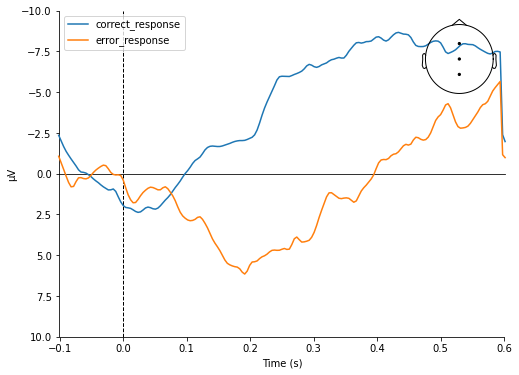

[<Figure size 576x432 with 2 Axes>]

In [208]:
# Averages of two event sets

mne.viz.plot_compare_evokeds(dict(correct_response=correct_response_evoked, error_response=error_response_evoked),
                             legend='upper left', 
                             show_sensors='upper right', 
                             ylim=dict(eeg=[-10, 10]), 
                             invert_y=True,
                             combine='mean')

No projector specified for this dataset. Please consider the method self.add_proj.


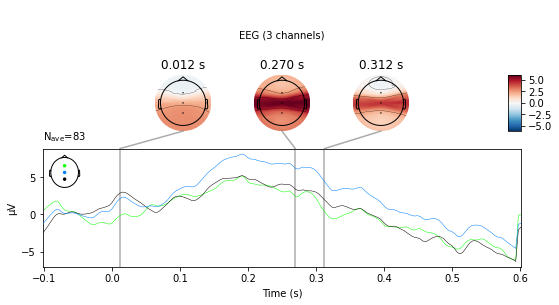

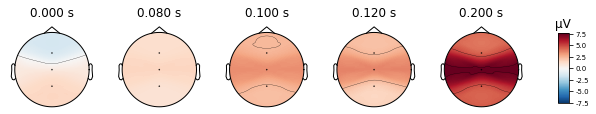

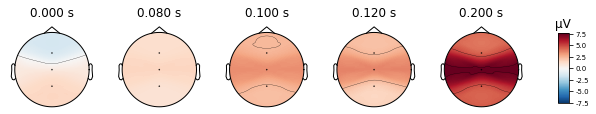

In [209]:
# Averages of error response events per channel

error_response_evoked.plot_joint(picks='eeg')
error_response_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2], ch_type='eeg')

No projector specified for this dataset. Please consider the method self.add_proj.


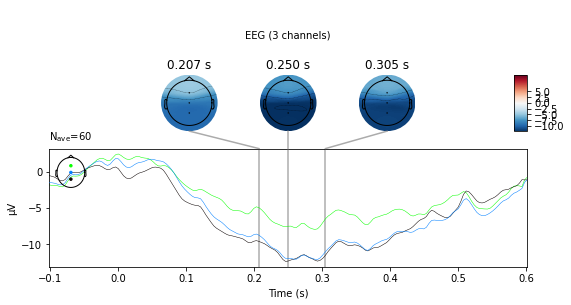

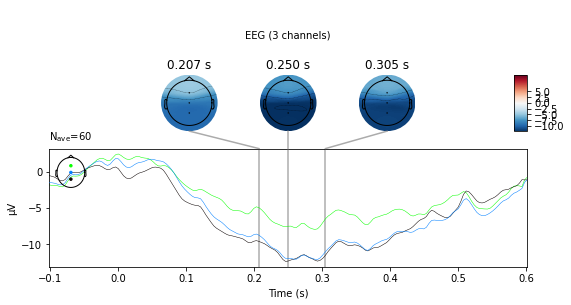

In [210]:
# Averages of merged event sets (diff between error and correct) per channel

evoked_diff = mne.combine_evoked([correct_response_evoked, error_response_evoked], weights=[1, -1])
evoked_diff.plot_joint()


In [ ]:
events_mean_dict = {}

for key in merged_event_dict.keys():
    mean_key = key + '_mean'
    events_mean_dict[mean_key] = epochs[key]._data.mean(axis=(0))

In [ ]:
# Chart with averages of correct and error responses per channel

colors = ['b', 'r', 'g']
color_iterator = 0

plt.figure(figsize=(10, 10))

   
for key in events_mean_dict:
    epoch = events_mean_dict[key]
    plt.plot(epoch.T + np.arange(start=1e-6, step=10e-6, stop=301e-7), label=key, color=colors[color_iterator]) 
    color_iterator = color_iterator+1

plt.yticks([]) 
plt.xticks(np.arange(0, 181, 181/8), np.arange(0, 800, 100))
plt.xlabel('milliseconds', fontsize=15)
plt.ylabel('channels', fontsize=15)
plt.legend(loc="upper left")
plt.show()

## Pre-processing

**Pre-processing done with Brain Vision Software:**

- Notch filter  0.05-25
- Baseline Correction //what baseline?
- OcularCorrection
- Artifact Rejection

**TOTHINK**

- downsampling
- additional bandpass filter

## Feature extraction

Feature extraction recommended for eeg data is **Wavelet Transform** (especially **Discrite Wavelet Transform**). Better that FFT for biomedical signals because of its localization characteristics of non-stationary signals in time and frequency domains. DWT decompositing signal into five frequency bands.

https://en.wikipedia.org/wiki/Discrete_wavelet_transform

https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0173138&type=printable

**Plan:**
- **5th level of DWT** because of 256 sampling rate ---> decomposition into five specific frequency: delta band (δ), theta band (θ), alpha band (α), beta band (β), and gamma band (γ)

        (The  six  sub-bands,  particularly cD1, cD2, cD3, cD4, cD5 and cA5, represented the frequency range from the band-limited EEG signal, where cA is the decomposition approximation coefficient and cDs are the decomposition detail coefficients)

- choosing mother of wavelet (**MWT**):
    - choose few families of filters (need to read about best)


- **parametrize classifier** with filter name (move vectorisation to classifier)
    - consider: after decomposition each signal into five frequency bands **featurize each band separately** with choosen function (mean, std etc.) 


- run classifiers and print **comparison** of all "parameters" (classifier x MWT x small_function)
    - with ANN eg. stop after ~1000 epoches, do comparison and choose best parameters

**TOTHINK** Feature selection